In [346]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load


df = pd.read_csv('data/network_activations_small_5000_trials.csv')
color_list = ['teal', 'salmon']
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }

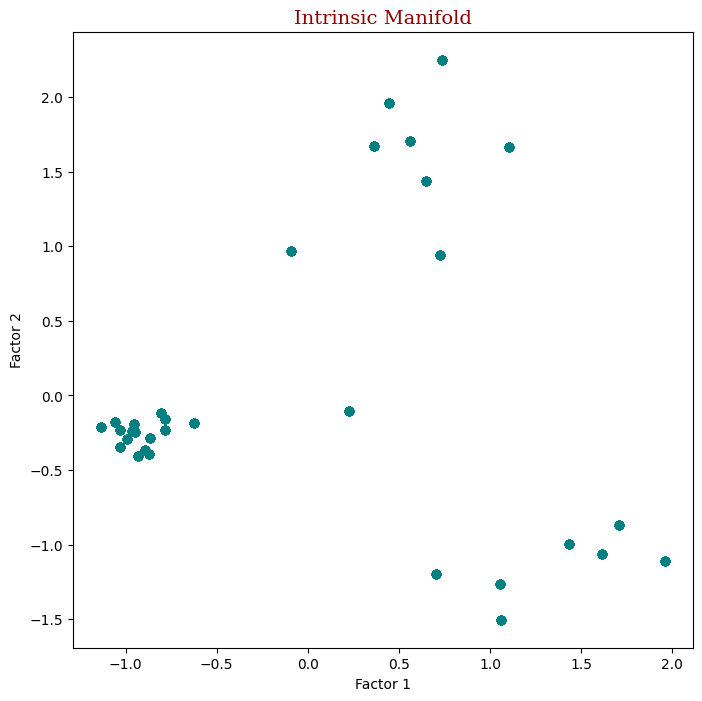

In [347]:
n_factors = 6
fa = FactorAnalysis(n_components=n_factors,rotation='varimax')
manifold = fa.fit_transform(df)
dump(fa, 'fa_model.joblib')
factor_scores = manifold

# Create a scatter plot of the first two factors
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(manifold[:, 0], manifold[:, 1], alpha=0.05,color=color_list[0])
ax.set_xlabel('Factor 0')
ax.set_ylabel('Factor 1')
ax.set_title('Intrinsic Manifold', fontdict=font)
plt.savefig(f"figs/Intrinsic_Manifold.pdf")
plt.show()

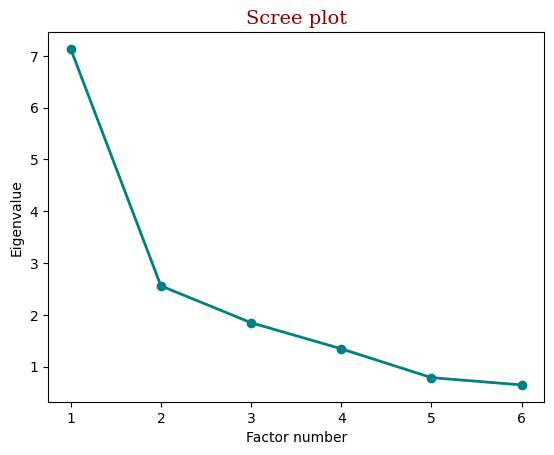

In [348]:
factor_loadings = fa.components_
eigenvalues = np.linalg.eigvals(factor_loadings.dot(factor_loadings.T))

sorted_eigenvalues = np.sort(eigenvalues)[::-1]

# Plot the eigenvalues against the factor number
plt.plot(np.arange(1, n_factors+1), sorted_eigenvalues, 'o-', linewidth=2,color=color_list[0])
plt.xlabel('Factor number')
plt.ylabel('Eigenvalue')
plt.title('Scree plot', fontdict=font)
plt.savefig(f"figs/scree_plot.pdf")
plt.show()

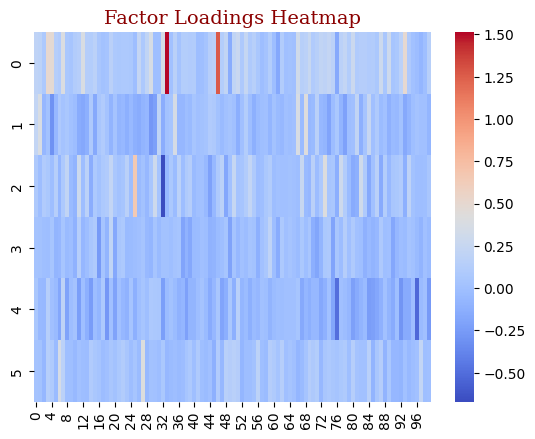

In [349]:
loadings = fa.components_

sns.heatmap(loadings, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Factor Loadings Heatmap', fontdict=font)
plt.savefig(f"figs/heatmap.pdf")
plt.show()

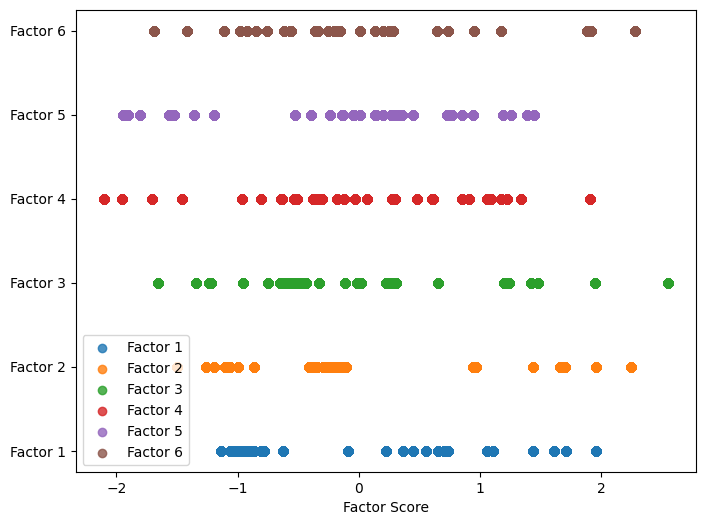

In [350]:
# Plot the factor scores as a scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(n_factors):
    ax.scatter(factor_scores[:, i], [i] * len(factor_scores), alpha=0.8, label=f"Factor {i+1}")
ax.legend()
ax.set_xlabel("Factor Score")
ax.set_yticks(range(n_factors))
ax.set_yticklabels([f"Factor {i+1}" for i in range(n_factors)])
plt.savefig(f"figs/factor_scores.pdf")
plt.show()

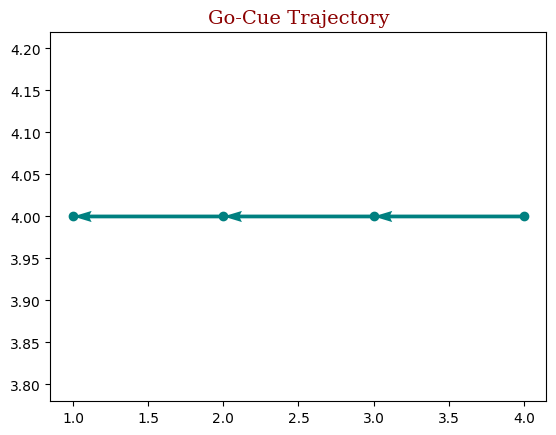

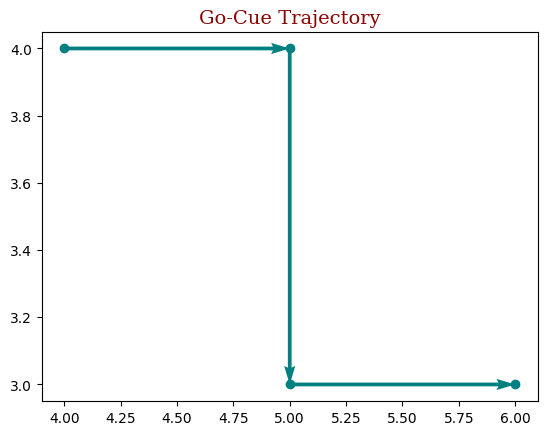

In [351]:
from scipy.stats import pearsonr, spearmanr


pos = np.loadtxt('positions.csv', delimiter=',')
factors = np.loadtxt('factors.csv', delimiter=',')

test_ids = pos[:, 0]
positions = pos[:, 1:3]

# Group positions by test ID
pos_groups = {}
factors_groups = {}
for test_id in np.unique(test_ids):
    idx = np.where(test_ids == test_id)
    test_positions = positions[idx]
    test_factors = factors[idx]
    pos_groups[test_id] = test_positions
    factors_groups[test_id] = test_factors

def plot_trajectory(pos,i):
    fig, ax = plt.subplots()
    ax.plot(pos[:, 0], pos[:, 1], '-o',color=color_list[0])
    dx = np.diff(pos[:, 0])
    dy = np.diff(pos[:, 1])
    arrow_x = pos[:-1, 0]
    arrow_y = pos[:-1, 1]
    arrow_dx = dx
    arrow_dy = dy
    ax.quiver(arrow_x, arrow_y, arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1,color=color_list[0])
    plt.title(f'Go-Cue Trajectory', fontdict=font)
    plt.savefig(f"figs/traj_{i}.pdf")
    plt.show()



for i in range(1,3):  
    plot_trajectory(pos_groups[i],i)



In [352]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
import pickle
from sklearn.neural_network import MLPRegressor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(factors, pos[:,3], test_size=0.1, random_state=42)

# Train a perceptron model for x position
model_action = MLPRegressor(hidden_layer_sizes=(6, 4), activation='relu', max_iter=1000)
model_action.fit(X_train, y_train)
with open('perceptron_model_action.pkl', 'wb') as file:
    pickle.dump(model_action, file)

# Evaluate the model on the testing set
score_x = model_action.score(X_test, y_test)
print('Model score (x position):', score_x)



# Use the models to predict the next position of the go cue for a new input
new_input = np.array([0.5, 0.2, 0.8, 0.1, 0.9, 0.3]) # example input
predicted_action = model_action.predict([new_input])

print('Predicted position (x, y):', predicted_action)


Model score (x position): 0.9999793996158755
Predicted position (x, y): [4.15382273]


In [353]:
# Use the model to predict the go cue positions for the test inputs
x_pred = model_action.predict(X_test)

# Calculate the mean squared error between the predicted and actual go cue positions
mse = ((x_pred - y_test) ** 2).mean()
print('Mean squared error:', mse)

Mean squared error: 2.486321646130865e-05
